In [1]:
!pip install evaluate rouge_score git+https://github.com/google-research/bleurt.git bert_score

  Cloning https://github.com/google-research/bleurt.git to /tmp/pip-req-build-qv3rh2d6
  Running command git clone --filter=blob:none --quiet https://github.com/google-research/bleurt.git /tmp/pip-req-build-qv3rh2d6
  Resolved https://github.com/google-research/bleurt.git to commit cebe7e6f996b40910cfaa520a63db47807e3bf5c
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 8.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.1/61.1 kB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.2/491.2 kB 46.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 13.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 183.9/183.9 kB 19.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 12.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 1.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [2]:
!pip install openai

In [3]:
!pip install datasets

In [4]:
from datasets import load_dataset
dataset_xlcost = load_dataset("codeparrot/xlcost-text-to-code", "Python-program-level")['test']
dataset_code_x = load_dataset("google/code_x_glue_ct_code_to_text", 'python')['test']
dataset_code_search_net = load_dataset("code-search-net/code_search_net", 'python')['test']

README.md:   0%|          | 0.00/3.32k [00:00<?, ?B/s]

xlcost-text-to-code.py:   0%|          | 0.00/7.61k [00:00<?, ?B/s]

0000.parquet:   0%|          | 0.00/3.92M [00:00<?, ?B/s]

0000.parquet:   0%|          | 0.00/357k [00:00<?, ?B/s]

0000.parquet:   0%|          | 0.00/200k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/9263 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/887 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/472 [00:00<?, ? examples/s]

README.md:   0%|          | 0.00/26.7k [00:00<?, ?B/s]

train-00000-of-00002.parquet:   0%|          | 0.00/144M [00:00<?, ?B/s]

train-00001-of-00002.parquet:   0%|          | 0.00/147M [00:00<?, ?B/s]

validation-00000-of-00001.parquet:   0%|          | 0.00/16.7M [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/18.0M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/251820 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/13914 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/14918 [00:00<?, ? examples/s]

README.md:   0%|          | 0.00/12.9k [00:00<?, ?B/s]

code_search_net.py:   0%|          | 0.00/8.44k [00:00<?, ?B/s]

The repository for code-search-net/code_search_net contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/code-search-net/code_search_net.
You can avoid this prompt in future by passing the argument `trust_remote_code=True`.

Do you wish to run the custom code? [y/N] y


python.zip:   0%|          | 0.00/941M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/412178 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/22176 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/23107 [00:00<?, ? examples/s]

In [5]:
def split_text(example):
    example['text'] = example['text'].split('|')[0].strip()
    return example

dataset_xlcost = dataset_xlcost.map(split_text)

dataset_code_x = dataset_code_x.rename_column('docstring', 'text')

dataset_code_search_net = dataset_code_search_net.rename_column('func_documentation_string', 'text')
dataset_code_search_net = dataset_code_search_net.rename_column('func_code_string', 'code')

Map:   0%|          | 0/887 [00:00<?, ? examples/s]

In [17]:
from openai import OpenAI

client = OpenAI(
  base_url="https://openrouter.ai/api/v1",
  api_key="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",
)

In [7]:
system_message = {
      "role": "system",
      "content": "For each code snippet provided as input, output a very brief summary and nothing else. The summary must not include newline characters or full stop symbols. The number of summary outputs must exactly match the number of input code snippets, with each summary separated by the '$' symbol if there are multiple snippets"
    }

In [22]:
import os
import json

def save_to_json(dataset, summaries, references, left, right, filename):
    # Создаем список данных для сохранения
    output_data = []
    for i in range(len(references)):
        if i >= len(summaries):
            break  # Защита от расхождения длин

        sample_idx = left + i
        entry = {
            "code": dataset[sample_idx]['code'],
            "ideal_answer": references[i],
            "generated_answer": summaries[i].strip()
        }
        output_data.append(entry)

    # Создаем директорию, если она не существует
    directory = os.path.dirname(filename)
    if directory and not os.path.exists(directory):
        os.makedirs(directory, exist_ok=True)

    # Сохраняем данные в JSON
    with open(filename, 'w', encoding='utf-8') as f:
        json.dump(output_data, f, ensure_ascii=False, indent=2)

In [9]:
def get_summarization(model, dataset, left, right):
    codes = ""
    refs = []
    for sample in dataset.select(range(left,right)):
        codes +=sample['code'] + "\n$\n"
        refs.append(sample['text'])
    print(len(codes))
    completion = client.chat.completions.create(
        model = model,
        messages=[
          system_message,
          {
            "role": "user",
            "content": codes
          }
        ]
    )
    summary = completion.choices[0].message.content.split('$')

    return summary, refs

In [10]:
import evaluate
bleu = evaluate.load("bleu")
rouge = evaluate.load("rouge")
bleurt = evaluate.load("bleurt", module_type="metric", checkpoint="bleurt-base-128")
bertscore = evaluate.load("bertscore")

In [11]:
def calculate_metrics(preds, refs):
    rouge_result = rouge.compute(predictions=preds, references=refs, rouge_types=["rougeL"])["rougeL"]
    bleu_result = bleu.compute(predictions=preds, references=[[ref] for ref in refs])

    bleurt_scores = bleurt.compute(predictions=preds, references=refs)["scores"]
    avg_bleurt = sum(bleurt_scores) / len(bleurt_scores)

    bert_scores = bertscore.compute(
        predictions=preds,
        references=refs,
        lang="en",
        model_type="microsoft/deberta-large-mnli"
    )
    avg_bert_f1 = sum(bert_scores["f1"]) / len(bert_scores["f1"])


    return rouge_result, bleurt_scores, bert_scores, avg_bert_f1

In [37]:
import json

def calculate_metrics_from_file(json_filename):
    # Открываем JSON-файл и загружаем данные
    with open(json_filename, 'r', encoding='utf-8') as f:
        data = json.load(f)

    # Извлекаем "идеальные ответы" и "сгенерированные ответы"
    references = [entry["ideal_answer"] for entry in data]
    predictions = [entry["generated_answer"] for entry in data]

    # Вычисляем метрики
    rouge_result = rouge.compute(predictions=predictions, references=references, rouge_types=["rougeL"])["rougeL"]
    bleu_result = bleu.compute(predictions=predictions, references=[[ref] for ref in references])["bleu"]
    bleurt_scores = bleurt.compute(predictions=predictions, references=references)["scores"]
    avg_bleurt = sum(bleurt_scores) / len(bleurt_scores)

    bert_scores = bertscore.compute(
        predictions=predictions,
        references=references,
        lang="en",
        model_type="microsoft/deberta-large-mnli"
    )
    avg_bert_f1 = sum(bert_scores["f1"]) / len(bert_scores["f1"])

    # Печатаем результаты
    print("ROUGE-L Score:", rouge_result)
    print("BLEU Score:", bleu_result)
    print("BLEURT Scores:", bleurt_scores)
    print("Average BLEURT Score:", avg_bleurt)
    print("Average BERTScore F1:", avg_bert_f1)

    # Возвращаем результаты
    return {
        "rouge_l": rouge_result,               # Скалярное значение ROUGE-L
        "bleu": bleu_result,                   # Скалярное значение BLEU
        "bleurt_scores": bleurt_scores,       # Список значений BLEURT
        "avg_bleurt": avg_bleurt,             # Среднее значение BLEURT
        "bert_scores": bert_scores["f1"],     # Список значений BERTScore F1
        "avg_bert_f1": avg_bert_f1            # Среднее значение BERTScore F1
    }

In [40]:
import matplotlib.pyplot as plt

def plot_metrics_from_file(json_filename):
    # Вычисляем метрики с помощью функции calculate_metrics_from_file
    results = calculate_metrics_from_file(json_filename)

    # Извлекаем данные для графика
    metrics = ["ROUGE-L", "BLEU", "Avg BLEURT", "Avg BERTScore F1"]
    scores = [
        results["rouge_l"],          # ROUGE-L
        results["bleu"],             # BLEU
        results["avg_bleurt"],       # Среднее значение BLEURT
        results["avg_bert_f1"]       # Среднее значение BERTScore F1
    ]

    # Создаём график
    plt.figure(figsize=(10, 6))
    plt.bar(metrics, scores, color='skyblue', edgecolor='black')

    # Добавляем заголовок с названием файла
    plt.title(f"Metrics for {json_filename}", fontsize=16)

    # Подписываем оси
    plt.xlabel("Metrics", fontsize=14)
    plt.ylabel("Scores", fontsize=14)

    # Добавляем значения над столбцами
    for i, score in enumerate(scores):
        plt.text(i, score + 0.01, f"{score:.2f}", ha='center', fontsize=12)

    # Настройка внешнего вида
    ymin = min(scores) - 0.1  # Минимальное значение с небольшим отступом
    ymax = max(scores) + 0.1  # Максимальное значение с небольшим отступом
    plt.ylim(ymin, ymax)  # Устанавливаем пределы по оси Y

    plt.grid(axis='y', linestyle='--', alpha=0.7)

    # Показываем график
    plt.tight_layout()
    plt.show()

12771
['minSum function calculates minimum sum after removing one element frequency', 'maxAdjacent function prints maximum adjacent difference for each element excluding itself', 'findSize and CountOnes functions count ones in a specific range of a binary representation', 'minDivisior function prints minimum divisor and resulting value for a given number', "Landau_function calculates Landau's function for a given number using recursion and LCM", 'gcd and lcm functions are used to calculate LCM of array elements', 'isPrime checks if a number is prime and checkExpression verifies a condition', "checkArray checks if it's possible to get K odd elements from the given array", 'func calculates a specific sum based on frequency and values of array elements', 'insert_element determines the element to be inserted to satisfy XOR and sum conditions', "checkSolution checks if a equals c regardless of b's value", 'isPerfectSquare checks if a number is perfect square and checkSunnyNumber verifies a 

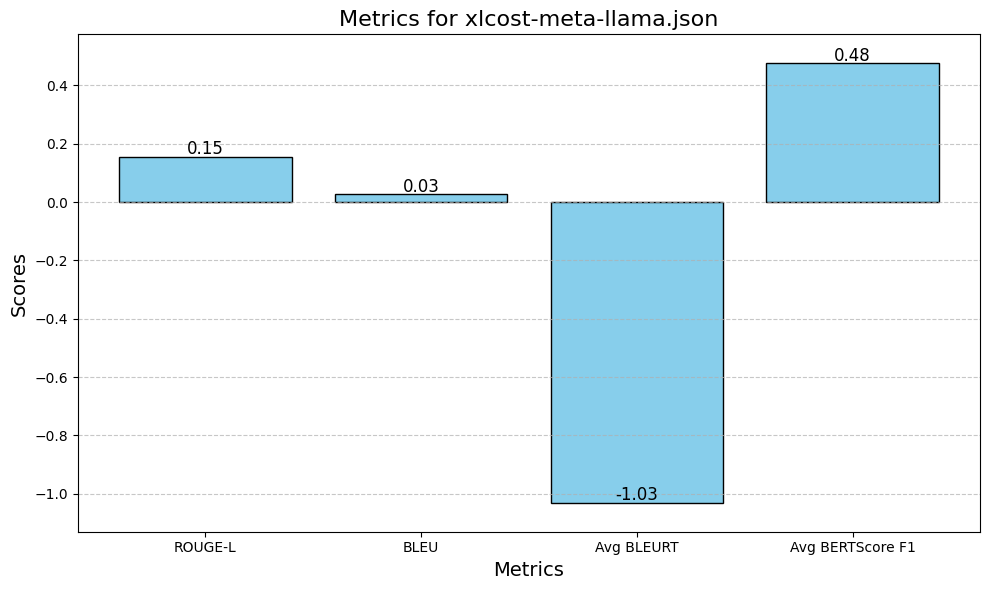

In [41]:
preds, refs = get_summarization("meta-llama/llama-4-maverick:free", dataset_xlcost, 0, 20)
if len(preds)>len(refs):
    preds = preds[:len(refs)]
print(preds)
save_to_json(dataset_xlcost, preds, refs, 0, 20, "xlcost-meta-llama.json")
plot_metrics_from_file("xlcost-meta-llama.json")
# res = calculate_metrics_from_file("xlcost-meta-llama.json")


In [ ]:
preds, refs = get_summarization("deepseek/deepseek-chat-v3-0324:free", dataset_code_x , 0, 100)
rouge_result, bleurt_scores, bert_scores, avg_bert_f1 = calculate_metrics(preds,refs)

print("\rouge_result:", rouge_result)
print("bleurt_scores:", bleurt_scores)
print(f"bert_scores:", bert_scores)
print(f"avg_bert_f1 F1", avg_bert_f1)


In [ ]:
preds, refs = get_summarization("deepseek/deepseek-chat-v3-0324:free", dataset_code_search_net , 0, 100)
rouge_result, bleurt_scores, bert_scores, avg_bert_f1 = calculate_metrics(preds,refs)

print("\rouge_result:", rouge_result)
print("bleurt_scores:", bleurt_scores)
print(f"bert_scores:", bert_scores)
print(f"avg_bert_f1 F1", avg_bert_f1)
